## Crew Number PyTorch

### This notebook shows about training an model to predict the Crew number step by step


### 1. Import dependencies

In [1]:
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import OneHotEncoder
import visuals as vs
from torch import optim
import os

### 2. Load the data and show preview

In [2]:
data = pd.read_csv("cruise_ship_info.csv")
data

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00
...,...,...,...,...,...,...,...,...,...
153,Taurus,Star,22,3.341,0.66,2.79,0.33,50.62,0.59
154,Virgo,Star,14,76.800,19.60,8.79,9.67,39.18,12.00
155,Spirit,Windstar,25,5.350,1.58,4.40,0.74,33.86,0.88
156,Star,Windstar,27,5.350,1.67,4.40,0.74,32.04,0.88


### 3.  Separe the crew (that we want predict) from the features and get the numpy arrays

In [3]:
crew = data['crew']
features = data.drop('crew', axis = 1)
features.shape, crew.shape

((158, 8), (158,))

### 4. Show basic statistics about the dataset

In [4]:
print("Statistics for Cruise Ship dataset:\n")
print("Minimum crew: {}".format(crew.min())) 
print("Maximum crew: {}".format(crew.max()))
print("Mean crew: {}".format(crew.mean()))
print("Median crew {}".format(np.median(crew)))
print("Standard deviation of crew value: {}".format(crew.std()))
print("Total of crew values: {}".format(crew.count()))

Statistics for Cruise Ship dataset:

Minimum crew: 0.59
Maximum crew: 21.0
Mean crew: 7.794177215189873
Median crew 8.15
Standard deviation of crew value: 3.503486564627033
Total of crew values: 158


We can see that the difference between the minimum and maximum crew size are large so we can infer that we are working with really small ships and with really large ones 

### 5. Choose the best features for a crew predictor
At first for sure i would remove the **Ship_name** since each ship has one so it isn't useful, and intuitivelly remove **Age** and **Cruise_line** but i rather check which is the feature importance. The features **Tonnage**, **passengers**, **length**, **passenger_density** and **cabins** in my point of view are all importants since a crew value should be choosen depending on the demand of those features (Higher the features value also would be the crew).

In [5]:
# Delete the Ship_name column from the input data 
data_clean = features.drop('Ship_name', axis = 1)
data_clean[:3]

,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density
0,Azamara,6,30.277,6.94,5.94,3.55,42.64
1,Azamara,6,30.277,6.94,5.94,3.55,42.64
2,Carnival,26,47.262,14.86,7.22,7.43,31.80


#### 5.1. One Hot Encode the Cruise_line feature

In [6]:
# Get one hot encoding of columns Cruise_line
one_hot = pd.get_dummies(data_clean['Cruise_line'])
# Drop column Cruise_line as it is now encoded
data_clean = data_clean.drop('Cruise_line',axis = 1)
# Join the encoded df
data_clean = data_clean.join(one_hot)
print(data_clean.shape)
data_clean[:3]


(158, 26)


,Age,Tonnage,passengers,length,cabins,passenger_density,Azamara,Carnival,Celebrity,Costa,...,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
0,6,30.277,6.94,5.94,3.55,42.64,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,30.277,6.94,5.94,3.55,42.64,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,47.262,14.86,7.22,7.43,31.80,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 5.3 Check the feature importance without the Cruise_line and with all the features

In [7]:
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot

X = data_clean.values
y = crew.values

lr = LinearRegression()
lr.fit(X,y)

LinearRegression()

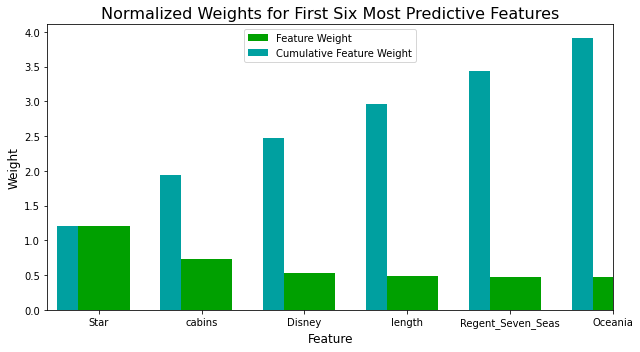

In [8]:
importance = lr.coef_
# summarize feature importance
vs.feature_plot(importance,data_clean,crew)

#### 5.4 Drop columns with less important features
After checking the importance of the features will drop a the columns that aren't useful for our models

In [9]:
indices = np.argsort(importance)[::-1]
print(np.sort(importance))
print("Less important features: ", data_clean.columns.values[indices[16:]])
data_clean = data_clean.drop(data_clean.columns.values[indices[16:]], axis=1)
X = data_clean.values

[-1.29862723e+00 -6.47536545e-01 -5.22423960e-01 -5.15718963e-01
 -3.51419944e-01 -2.20675165e-01 -1.81687618e-01 -1.48694789e-01
 -9.79161172e-02 -8.00197332e-02  7.39850930e-04  2.23069281e-03
  7.27089135e-03  1.45775342e-02  8.19339183e-02  1.10020048e-01
  1.51424518e-01  2.08264661e-01  3.03465301e-01  4.08654152e-01
  4.74881573e-01  4.78986876e-01  4.85078106e-01  5.35711740e-01
  7.24860091e-01  1.21123046e+00]
Less important features:  ['Cunard' 'passengers' 'Princess' 'P&O' 'MSC' 'Windstar' 'Costa' 'Orient'
 'Holland_American' 'Royal_Caribbean']


### 6. Convert the data to PyTorch format

In [10]:
train_len = 95
valid_len = 63

# Convert dataset to PyTorch
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [train_len, valid_len])
train_loader = DataLoader(train_ds, 1)
val_loader = DataLoader(val_ds, 1)

### 7. Create the architecture of the model

In [11]:
class ShipModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)
        
    def forward(self, input_): 
        out = self.linear(input_)
        return out
model = ShipModel(data_clean.shape[1])

### 8. Set the main hyper-parameters
the hyper-parameters need to be used to make the model to converge, if you choose a higher learning rater for example the model would overfit and if you choose a really small learning rate it will underfit, the same for the quantity of epochs you choose. 

In [12]:
# Mean Square Error was choosen since its a great loss for a Regression problem 
criterion = nn.MSELoss()
# The Learning rate was tuned to find the best one to fit the data without causing overfitting or underfitting
learning_rate=0.000004
# SGD Was used since ts a great Optimizer used for general purposes
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Epochs
epochs = 20
# Assign to the device
model.to("cpu")

ShipModel(
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

### 9. Define training function

In [13]:
def train(model, trainloader, testloader, epochs, criterion, optmizer, model_name):
    steps = 0
    running_loss = 0
    print_every = 1
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        for inputs, values in trainloader:
            steps += 1
            inputs, values = inputs.to("cpu"), values.to("cpu")
            logps = model.forward(inputs)
            loss = criterion(logps, values)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss.item()
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, values in testloader:
                        inputs, values = inputs.to("cpu"), values.to("cpu")
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, values)
                        test_loss += batch_loss.item()

                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                val_loss_fix = round(test_loss/len(testloader),3)

                print(f"Epoch {epoch+1}/{epochs}.. "
                       f"Train loss: {running_loss/print_every:.3f}.. "
                       f"Validation loss: {val_loss_fix}.. ")
                running_loss = 0
                model.train()
    #       Save every epoch
            if not os.path.exists('models/'+model_name+'/'):
                os.mkdir('models/'+model_name+'/')
            model_full_name = 'models/'+model_name+'/epoch_'+str(epoch)+'_name_'+model_name+'_.pt'
            torch.save(model, model_full_name) # official recommended

### 10. Train the model!

In [14]:
train(model ,train_loader, val_loader, epochs, criterion, optimizer, "model_all")

Epoch 1/20.. Train loss: 0.856.. Validation loss: 26.026.. 
Epoch 1/20.. Train loss: 2.573.. Validation loss: 26.577.. 
Epoch 1/20.. Train loss: 2.556.. Validation loss: 25.986.. 
Epoch 1/20.. Train loss: 9.035.. Validation loss: 24.119.. 
Epoch 1/20.. Train loss: 4.824.. Validation loss: 22.88.. 
Epoch 1/20.. Train loss: 4.524.. Validation loss: 21.719.. 
Epoch 1/20.. Train loss: 6.148.. Validation loss: 20.543.. 
Epoch 1/20.. Train loss: 5.958.. Validation loss: 20.886.. 
Epoch 1/20.. Train loss: 9.089.. Validation loss: 19.568.. 
Epoch 1/20.. Train loss: 1.317.. Validation loss: 19.669.. 
Epoch 1/20.. Train loss: 0.069.. Validation loss: 19.608.. 
Epoch 1/20.. Train loss: 0.205.. Validation loss: 19.487.. 
Epoch 1/20.. Train loss: 2.540.. Validation loss: 19.575.. 
Epoch 1/20.. Train loss: 33.075.. Validation loss: 16.487.. 
Epoch 1/20.. Train loss: 9.333.. Validation loss: 16.753.. 
Epoch 1/20.. Train loss: 1.801.. Validation loss: 16.336.. 
Epoch 1/20.. Train loss: 8.595.. Validat

/media/crystal/main_files/Repositorios/Research-tools-study/ml_task/cruise_ship_ml/cruise_env/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/media/crystal/main_files/Repositorios/Research-tools-study/ml_task/cruise_ship_ml/cruise_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ShipModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1/20.. Train loss: 22.247.. Validation loss: 13.465.. 
Epoch 1/20.. Train loss: 0.320.. Validation loss: 13.326.. 
Epoch 1/20.. Train loss: 0.988.. Validation loss: 12.995.. 
Epoch 1/20.. Train loss: 0.317.. Validation loss: 12.855.. 
Epoch 1/20.. Train loss: 0.651.. Validation loss: 12.747.. 
Epoch 1/20.. Train loss: 0.619.. Validation loss: 12.498.. 
Epoch 1/20.. Train loss: 2.812.. Validation loss: 12.801.. 
Epoch 1/20.. Train loss: 92.244.. Validation loss: 8.154.. 
Epoch 1/20.. Train loss: 0.285.. Validation loss: 8.252.. 
Epoch 1/20.. Train loss: 0.817.. Validation loss: 8.07.. 
Epoch 1/20.. Train loss: 0.308.. Validation loss: 8.161.. 
Epoch 1/20.. Train loss: 9.228.. Validation loss: 7.419.. 
Epoch 1/20.. Train loss: 3.339.. Validation loss: 7.172.. 
Epoch 1/20.. Train loss: 1.149.. Validation loss: 7.237.. 
Epoch 1/20.. Train loss: 8.036.. Validation loss: 7.407.. 
Epoch 1/20.. Train loss: 7.056.. Validation loss: 7.583.. 
Epoch 1/20.. Train loss: 5.409.. Validation loss

Epoch 2/20.. Train loss: 1.270.. Validation loss: 3.942.. 
Epoch 2/20.. Train loss: 0.020.. Validation loss: 3.926.. 
Epoch 2/20.. Train loss: 0.902.. Validation loss: 4.0.. 
Epoch 2/20.. Train loss: 0.398.. Validation loss: 4.069.. 
Epoch 2/20.. Train loss: 0.001.. Validation loss: 4.072.. 
Epoch 2/20.. Train loss: 4.999.. Validation loss: 4.136.. 
Epoch 2/20.. Train loss: 1.303.. Validation loss: 4.267.. 
Epoch 2/20.. Train loss: 0.202.. Validation loss: 4.194.. 
Epoch 2/20.. Train loss: 0.514.. Validation loss: 4.131.. 
Epoch 2/20.. Train loss: 1.189.. Validation loss: 4.221.. 
Epoch 2/20.. Train loss: 0.174.. Validation loss: 4.156.. 
Epoch 2/20.. Train loss: 0.012.. Validation loss: 4.149.. 
Epoch 2/20.. Train loss: 0.043.. Validation loss: 4.134.. 
Epoch 2/20.. Train loss: 37.491.. Validation loss: 5.3.. 
Epoch 2/20.. Train loss: 1.543.. Validation loss: 5.075.. 
Epoch 2/20.. Train loss: 0.069.. Validation loss: 5.117.. 
Epoch 2/20.. Train loss: 9.613.. Validation loss: 4.493.. 


Epoch 4/20.. Train loss: 0.649.. Validation loss: 2.403.. 
Epoch 4/20.. Train loss: 4.416.. Validation loss: 2.433.. 
Epoch 4/20.. Train loss: 5.378.. Validation loss: 2.229.. 
Epoch 4/20.. Train loss: 0.085.. Validation loss: 2.239.. 
Epoch 4/20.. Train loss: 0.340.. Validation loss: 2.219.. 
Epoch 4/20.. Train loss: 0.041.. Validation loss: 2.211.. 
Epoch 4/20.. Train loss: 1.766.. Validation loss: 2.212.. 
Epoch 4/20.. Train loss: 0.509.. Validation loss: 2.228.. 
Epoch 4/20.. Train loss: 0.195.. Validation loss: 2.234.. 
Epoch 4/20.. Train loss: 0.501.. Validation loss: 2.249.. 
Epoch 4/20.. Train loss: 0.033.. Validation loss: 2.255.. 
Epoch 4/20.. Train loss: 0.009.. Validation loss: 2.259.. 
Epoch 4/20.. Train loss: 0.185.. Validation loss: 2.24.. 
Epoch 4/20.. Train loss: 3.150.. Validation loss: 2.27.. 
Epoch 4/20.. Train loss: 1.418.. Validation loss: 2.304.. 
Epoch 4/20.. Train loss: 0.832.. Validation loss: 2.256.. 
Epoch 4/20.. Train loss: 24.625.. Validation loss: 2.546..

Epoch 5/20.. Train loss: 1.541.. Validation loss: 2.897.. 
Epoch 5/20.. Train loss: 0.726.. Validation loss: 3.001.. 
Epoch 5/20.. Train loss: 19.398.. Validation loss: 1.92.. 
Epoch 5/20.. Train loss: 1.571.. Validation loss: 2.001.. 
Epoch 5/20.. Train loss: 0.155.. Validation loss: 2.026.. 
Epoch 5/20.. Train loss: 0.952.. Validation loss: 1.93.. 
Epoch 6/20.. Train loss: 0.719.. Validation loss: 1.95.. 
Epoch 6/20.. Train loss: 0.386.. Validation loss: 1.969.. 
Epoch 6/20.. Train loss: 0.284.. Validation loss: 1.95.. 
Epoch 6/20.. Train loss: 2.979.. Validation loss: 2.081.. 
Epoch 6/20.. Train loss: 1.264.. Validation loss: 2.176.. 
Epoch 6/20.. Train loss: 0.876.. Validation loss: 2.265.. 
Epoch 6/20.. Train loss: 0.072.. Validation loss: 2.289.. 
Epoch 6/20.. Train loss: 0.014.. Validation loss: 2.292.. 
Epoch 6/20.. Train loss: 1.271.. Validation loss: 2.198.. 
Epoch 6/20.. Train loss: 0.483.. Validation loss: 2.188.. 
Epoch 6/20.. Train loss: 0.001.. Validation loss: 2.187.. 


Epoch 7/20.. Train loss: 0.222.. Validation loss: 1.609.. 
Epoch 7/20.. Train loss: 0.063.. Validation loss: 1.62.. 
Epoch 7/20.. Train loss: 3.319.. Validation loss: 1.606.. 
Epoch 7/20.. Train loss: 0.309.. Validation loss: 1.622.. 
Epoch 7/20.. Train loss: 0.116.. Validation loss: 1.628.. 
Epoch 7/20.. Train loss: 0.107.. Validation loss: 1.636.. 
Epoch 7/20.. Train loss: 0.013.. Validation loss: 1.641.. 
Epoch 7/20.. Train loss: 0.001.. Validation loss: 1.642.. 
Epoch 7/20.. Train loss: 0.042.. Validation loss: 1.633.. 
Epoch 7/20.. Train loss: 0.827.. Validation loss: 1.653.. 
Epoch 7/20.. Train loss: 0.366.. Validation loss: 1.671.. 
Epoch 7/20.. Train loss: 0.535.. Validation loss: 1.638.. 
Epoch 7/20.. Train loss: 24.295.. Validation loss: 1.903.. 
Epoch 7/20.. Train loss: 1.080.. Validation loss: 1.8.. 
Epoch 7/20.. Train loss: 0.575.. Validation loss: 1.846.. 
Epoch 7/20.. Train loss: 0.625.. Validation loss: 1.796.. 
Epoch 7/20.. Train loss: 0.448.. Validation loss: 1.84.. 


Epoch 8/20.. Train loss: 0.589.. Validation loss: 1.777.. 
Epoch 9/20.. Train loss: 0.144.. Validation loss: 1.791.. 
Epoch 9/20.. Train loss: 0.018.. Validation loss: 1.785.. 
Epoch 9/20.. Train loss: 0.673.. Validation loss: 1.748.. 
Epoch 9/20.. Train loss: 2.779.. Validation loss: 1.89.. 
Epoch 9/20.. Train loss: 0.878.. Validation loss: 1.978.. 
Epoch 9/20.. Train loss: 0.580.. Validation loss: 2.057.. 
Epoch 9/20.. Train loss: 0.025.. Validation loss: 2.072.. 
Epoch 9/20.. Train loss: 0.203.. Validation loss: 2.058.. 
Epoch 9/20.. Train loss: 1.675.. Validation loss: 1.945.. 
Epoch 9/20.. Train loss: 1.155.. Validation loss: 1.926.. 
Epoch 9/20.. Train loss: 0.036.. Validation loss: 1.918.. 
Epoch 9/20.. Train loss: 0.054.. Validation loss: 1.93.. 
Epoch 9/20.. Train loss: 0.004.. Validation loss: 1.929.. 
Epoch 9/20.. Train loss: 1.619.. Validation loss: 1.803.. 
Epoch 9/20.. Train loss: 0.194.. Validation loss: 1.796.. 
Epoch 9/20.. Train loss: 0.716.. Validation loss: 1.75.. 


Epoch 10/20.. Train loss: 0.000.. Validation loss: 1.503.. 
Epoch 10/20.. Train loss: 0.015.. Validation loss: 1.498.. 
Epoch 10/20.. Train loss: 0.266.. Validation loss: 1.51.. 
Epoch 10/20.. Train loss: 0.132.. Validation loss: 1.52.. 
Epoch 10/20.. Train loss: 0.430.. Validation loss: 1.493.. 
Epoch 10/20.. Train loss: 24.240.. Validation loss: 1.745.. 
Epoch 10/20.. Train loss: 0.882.. Validation loss: 1.656.. 
Epoch 10/20.. Train loss: 0.518.. Validation loss: 1.699.. 
Epoch 10/20.. Train loss: 0.644.. Validation loss: 1.649.. 
Epoch 10/20.. Train loss: 0.422.. Validation loss: 1.691.. 
Epoch 10/20.. Train loss: 1.779.. Validation loss: 1.798.. 
Epoch 10/20.. Train loss: 0.103.. Validation loss: 1.83.. 
Epoch 10/20.. Train loss: 0.128.. Validation loss: 1.808.. 
Epoch 10/20.. Train loss: 0.000.. Validation loss: 1.808.. 
Epoch 10/20.. Train loss: 0.662.. Validation loss: 1.752.. 
Epoch 10/20.. Train loss: 0.274.. Validation loss: 1.715.. 
Epoch 10/20.. Train loss: 7.959.. Validati

Epoch 12/20.. Train loss: 0.858.. Validation loss: 1.674.. 
Epoch 12/20.. Train loss: 0.040.. Validation loss: 1.669.. 
Epoch 12/20.. Train loss: 0.706.. Validation loss: 1.736.. 
Epoch 12/20.. Train loss: 0.010.. Validation loss: 1.726.. 
Epoch 12/20.. Train loss: 0.148.. Validation loss: 1.706.. 
Epoch 12/20.. Train loss: 0.427.. Validation loss: 1.753.. 
Epoch 12/20.. Train loss: 0.401.. Validation loss: 1.717.. 
Epoch 12/20.. Train loss: 2.278.. Validation loss: 1.673.. 
Epoch 12/20.. Train loss: 1.016.. Validation loss: 1.741.. 
Epoch 12/20.. Train loss: 3.863.. Validation loss: 1.829.. 
Epoch 12/20.. Train loss: 7.808.. Validation loss: 1.51.. 
Epoch 12/20.. Train loss: 2.090.. Validation loss: 1.578.. 
Epoch 12/20.. Train loss: 0.047.. Validation loss: 1.591.. 
Epoch 12/20.. Train loss: 1.501.. Validation loss: 1.657.. 
Epoch 12/20.. Train loss: 0.032.. Validation loss: 1.641.. 
Epoch 12/20.. Train loss: 0.578.. Validation loss: 1.599.. 
Epoch 12/20.. Train loss: 0.068.. Validat

Epoch 13/20.. Train loss: 1.684.. Validation loss: 2.0.. 
Epoch 13/20.. Train loss: 0.124.. Validation loss: 2.05.. 
Epoch 13/20.. Train loss: 2.160.. Validation loss: 1.925.. 
Epoch 13/20.. Train loss: 0.360.. Validation loss: 1.97.. 
Epoch 13/20.. Train loss: 0.143.. Validation loss: 2.022.. 
Epoch 13/20.. Train loss: 1.183.. Validation loss: 1.951.. 
Epoch 13/20.. Train loss: 0.698.. Validation loss: 1.892.. 
Epoch 13/20.. Train loss: 50.451.. Validation loss: 3.098.. 
Epoch 13/20.. Train loss: 2.316.. Validation loss: 2.831.. 
Epoch 13/20.. Train loss: 0.045.. Validation loss: 2.863.. 
Epoch 13/20.. Train loss: 2.958.. Validation loss: 2.538.. 
Epoch 13/20.. Train loss: 1.805.. Validation loss: 2.482.. 
Epoch 13/20.. Train loss: 0.671.. Validation loss: 2.583.. 
Epoch 13/20.. Train loss: 9.668.. Validation loss: 1.75.. 
Epoch 13/20.. Train loss: 1.001.. Validation loss: 1.842.. 
Epoch 13/20.. Train loss: 0.019.. Validation loss: 1.854.. 
Epoch 13/20.. Train loss: 0.450.. Validation

Epoch 15/20.. Train loss: 0.051.. Validation loss: 1.45.. 
Epoch 15/20.. Train loss: 0.048.. Validation loss: 1.456.. 
Epoch 15/20.. Train loss: 0.373.. Validation loss: 1.433.. 
Epoch 15/20.. Train loss: 24.320.. Validation loss: 1.673.. 
Epoch 15/20.. Train loss: 0.803.. Validation loss: 1.591.. 
Epoch 15/20.. Train loss: 0.520.. Validation loss: 1.632.. 
Epoch 15/20.. Train loss: 0.624.. Validation loss: 1.585.. 
Epoch 15/20.. Train loss: 0.428.. Validation loss: 1.625.. 
Epoch 15/20.. Train loss: 1.732.. Validation loss: 1.728.. 
Epoch 15/20.. Train loss: 0.154.. Validation loss: 1.766.. 
Epoch 15/20.. Train loss: 0.150.. Validation loss: 1.743.. 
Epoch 15/20.. Train loss: 0.003.. Validation loss: 1.741.. 
Epoch 15/20.. Train loss: 0.657.. Validation loss: 1.686.. 
Epoch 15/20.. Train loss: 0.272.. Validation loss: 1.65.. 
Epoch 15/20.. Train loss: 7.300.. Validation loss: 1.431.. 
Epoch 15/20.. Train loss: 0.283.. Validation loss: 1.416.. 
Epoch 15/20.. Train loss: 1.488.. Validat

Epoch 17/20.. Train loss: 0.423.. Validation loss: 1.714.. 
Epoch 17/20.. Train loss: 0.438.. Validation loss: 1.677.. 
Epoch 17/20.. Train loss: 1.876.. Validation loss: 1.637.. 
Epoch 17/20.. Train loss: 0.929.. Validation loss: 1.701.. 
Epoch 17/20.. Train loss: 3.778.. Validation loss: 1.787.. 
Epoch 17/20.. Train loss: 7.195.. Validation loss: 1.485.. 
Epoch 17/20.. Train loss: 2.018.. Validation loss: 1.552.. 
Epoch 17/20.. Train loss: 0.041.. Validation loss: 1.564.. 
Epoch 17/20.. Train loss: 1.539.. Validation loss: 1.631.. 
Epoch 17/20.. Train loss: 0.027.. Validation loss: 1.617.. 
Epoch 17/20.. Train loss: 0.464.. Validation loss: 1.579.. 
Epoch 17/20.. Train loss: 0.062.. Validation loss: 1.571.. 
Epoch 17/20.. Train loss: 0.300.. Validation loss: 1.588.. 
Epoch 17/20.. Train loss: 0.163.. Validation loss: 1.6.. 
Epoch 17/20.. Train loss: 0.023.. Validation loss: 1.605.. 
Epoch 17/20.. Train loss: 0.484.. Validation loss: 1.56.. 
Epoch 17/20.. Train loss: 0.172.. Validatio

Epoch 18/20.. Train loss: 0.155.. Validation loss: 1.981.. 
Epoch 18/20.. Train loss: 1.066.. Validation loss: 1.915.. 
Epoch 18/20.. Train loss: 0.605.. Validation loss: 1.861.. 
Epoch 18/20.. Train loss: 50.925.. Validation loss: 3.061.. 
Epoch 18/20.. Train loss: 2.433.. Validation loss: 2.789.. 
Epoch 18/20.. Train loss: 0.038.. Validation loss: 2.818.. 
Epoch 18/20.. Train loss: 2.816.. Validation loss: 2.504.. 
Epoch 18/20.. Train loss: 1.454.. Validation loss: 2.454.. 
Epoch 18/20.. Train loss: 0.688.. Validation loss: 2.555.. 
Epoch 18/20.. Train loss: 8.984.. Validation loss: 1.751.. 
Epoch 18/20.. Train loss: 0.934.. Validation loss: 1.841.. 
Epoch 18/20.. Train loss: 0.015.. Validation loss: 1.852.. 
Epoch 18/20.. Train loss: 0.432.. Validation loss: 1.766.. 
Epoch 19/20.. Train loss: 0.000.. Validation loss: 1.767.. 
Epoch 19/20.. Train loss: 0.619.. Validation loss: 1.727.. 
Epoch 19/20.. Train loss: 0.732.. Validation loss: 1.684.. 
Epoch 19/20.. Train loss: 2.476.. Valid

Epoch 20/20.. Train loss: 0.007.. Validation loss: 1.433.. 
Epoch 20/20.. Train loss: 0.028.. Validation loss: 1.437.. 
Epoch 20/20.. Train loss: 0.353.. Validation loss: 1.417.. 
Epoch 20/20.. Train loss: 24.432.. Validation loss: 1.648.. 
Epoch 20/20.. Train loss: 0.798.. Validation loss: 1.569.. 
Epoch 20/20.. Train loss: 0.547.. Validation loss: 1.61.. 
Epoch 20/20.. Train loss: 0.593.. Validation loss: 1.565.. 
Epoch 20/20.. Train loss: 0.446.. Validation loss: 1.605.. 
Epoch 20/20.. Train loss: 1.671.. Validation loss: 1.704.. 
Epoch 20/20.. Train loss: 0.179.. Validation loss: 1.744.. 
Epoch 20/20.. Train loss: 0.137.. Validation loss: 1.722.. 
Epoch 20/20.. Train loss: 0.002.. Validation loss: 1.721.. 
Epoch 20/20.. Train loss: 0.632.. Validation loss: 1.667.. 
Epoch 20/20.. Train loss: 0.271.. Validation loss: 1.632.. 
Epoch 20/20.. Train loss: 7.064.. Validation loss: 1.42.. 
Epoch 20/20.. Train loss: 0.221.. Validation loss: 1.407.. 
Epoch 20/20.. Train loss: 1.400.. Validat

### 11. Show some predictions and compare with ground truth

In [15]:
for i in range(10):
    print("ground-truth: ",float(val_ds[i][1]), " Predicted: ",float(model(val_ds[i][0])))

ground-truth:  11.09000015258789  Predicted:  9.68852710723877
ground-truth:  7.599999904632568  Predicted:  8.337696075439453
ground-truth:  6.360000133514404  Predicted:  6.699223041534424
ground-truth:  7.199999809265137  Predicted:  7.96565580368042
ground-truth:  7.5  Predicted:  5.714795112609863
ground-truth:  7.599999904632568  Predicted:  6.462888717651367
ground-truth:  11.600000381469727  Predicted:  11.801243782043457
ground-truth:  1.9700000286102295  Predicted:  2.662522315979004
ground-truth:  1.600000023841858  Predicted:  2.18390154838562
ground-truth:  5.880000114440918  Predicted:  6.4373040199279785


### 12. Measure Pearson Corrrelation Coefficient

In [16]:
y_val = val_ds.dataset.tensors[1].cpu().detach().numpy()

pred_train = np.ones(95, dtype=np.float32)
y_train = np.ones(95, dtype=np.float32)

pred_val = np.ones(63, dtype=np.float32)
y_val = np.ones(63, dtype=np.float32)

count = 0
for point in train_ds:
    pred_train[count] = float(model(point[0]))
    y_train[count] = float(point[1])
    count+=1
    
count = 0
for point in val_ds:
    pred_val[count] = float(model(point[0]))
    y_val[count] = float(point[1])
    count+=1

corr_train = np.corrcoef(y_train,pred_train, np.float64)
print(corr_train)

corr_val = np.corrcoef(y_val,pred_val, np.float64)
print(corr_val)

[[1.        0.9358218]
 [0.9358218 1.       ]]
[[1.         0.93812422]
 [0.93812422 1.        ]]


### 13. Regularization
Regularization is used in order to avoid overfitting, for that the SGD Optimizer aproach already deals with L2 Regularization which is the same as this model trained.